In [1]:
import os
import pickle
import logging 
from openmmtools.multistate import MultiStateReporter
import tqdm
import numpy as np
from openeye import oechem

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
import matplotlib.transforms as transforms


## N501Y 14/98 TYR

### Load nc file

In [2]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/14/98/"
i = os.path.basename(os.path.dirname(out_dir))
phase = 'complex'
endstate = 1
aa = 'TYR'.lower()
length = '1ns'
with open(os.path.join(out_dir, f"{i}_{phase}_{endstate}.pickle"), "rb") as f:
    htf = pickle.load(f)


In [3]:
reporter = MultiStateReporter(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}.nc"), 'r')


DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/neq/14/98/98_complex_tyr_1ns_checkpoint.nc
DEBUG:openmmtools.multistate.multistatereporter:checkpoint_interval != on-file checkpoint interval! Using on file analysis interval of 1.


### Compute acceptance rates for neighboring pairs of states across all iterations and plot

In [7]:
states = range(24)
state_neighbors = []
for first, second in zip(states, states[1:]):
    state_neighbors.append((first, second))

In [8]:
acceptance_rates_all = []
for pair in tqdm.tqdm(state_neighbors):
    state_i = pair[0]
    state_j = pair[1]
    acceptance_rates = []
    for iteration in range(1, 1001):
        acceptance_rates.append(reporter.read_mixing_statistics(iteration)[0][state_i][state_j] / reporter.read_mixing_statistics(iteration)[1][state_i][state_j])
    acceptance_rates_all.append(acceptance_rates)

100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


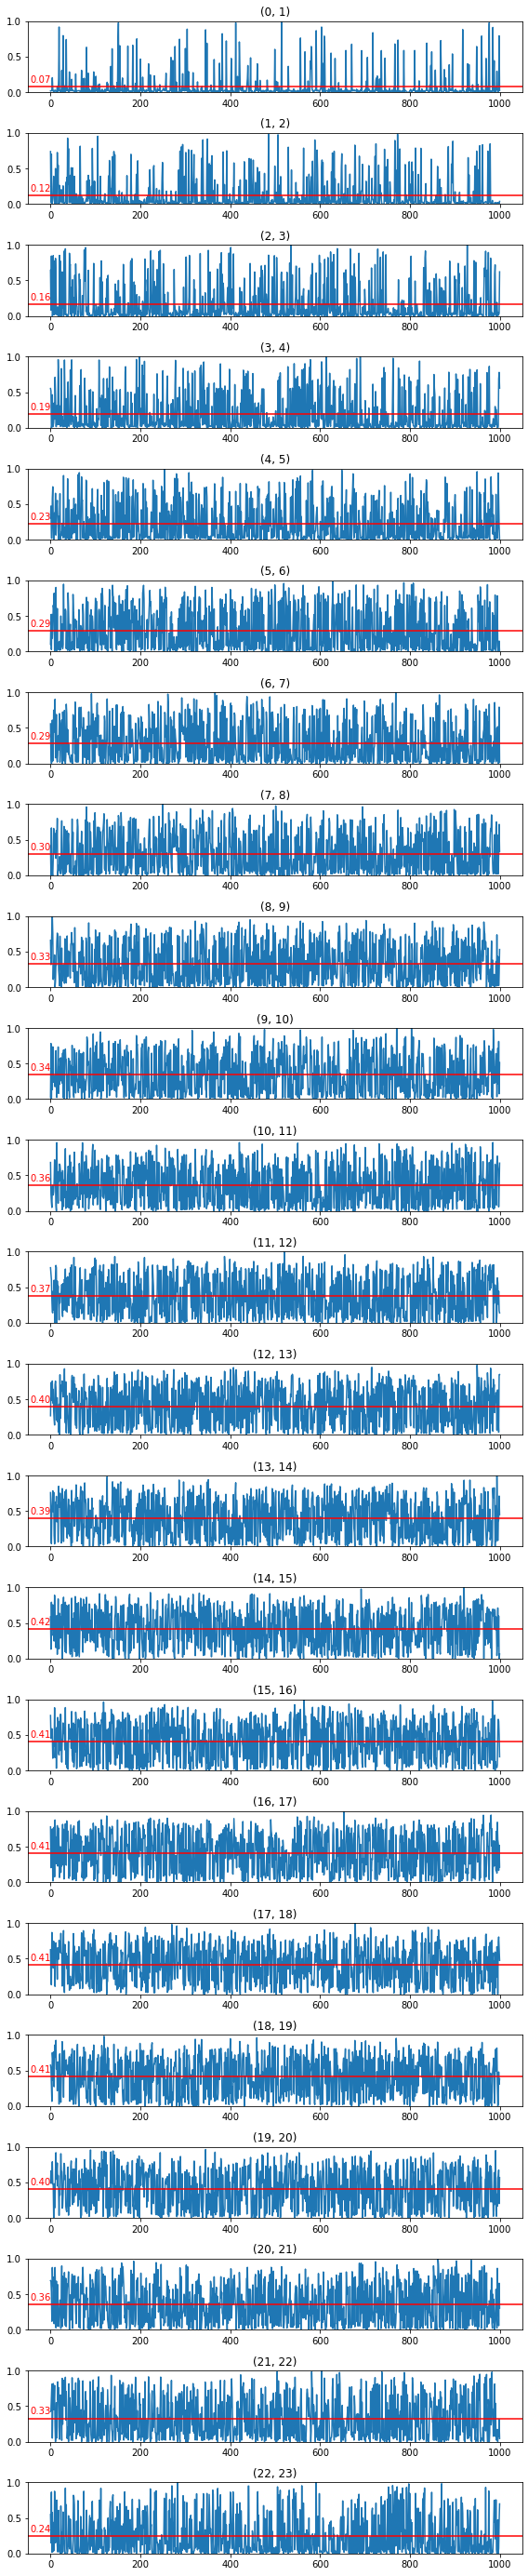

In [9]:
cols = 1
rows = 24
plt.figure(figsize=(8, 40))
gs = plt.GridSpec(rows, cols)
for i, (pair, acceptance_rates) in enumerate(zip(state_neighbors, acceptance_rates_all)):
    plt.subplot(gs[i,0])
    plt.plot(acceptance_rates)
    plt.title(pair)
    plt.ylim([0, 1])
    mean = np.mean(acceptance_rates)
    plt.axhline(y=mean, color="red")

#     trans = transforms.blended_transform_factory(
#         plt.yticks()[0].get_transform(), plt.transData)
    plt.text(0, mean + 0.1, "{:.2f}".format(mean), color="red", 
            ha="right", va="center")
plt.tight_layout()
plt.show()

### Generate plots of temperature vs iteration for each of the 24 walkers

In [4]:
from perses.analysis.utils import open_netcdf
i = os.path.basename(os.path.dirname(out_dir))
nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}.nc"))
nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)



In [5]:
replica_trajs = []
for i in tqdm.tqdm(range(24)):
    replica_traj = []
    for iteration in range(n_iter):
        replica_traj.append(nc.variables['states'][iteration][i])
    replica_trajs.append(replica_traj)

100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

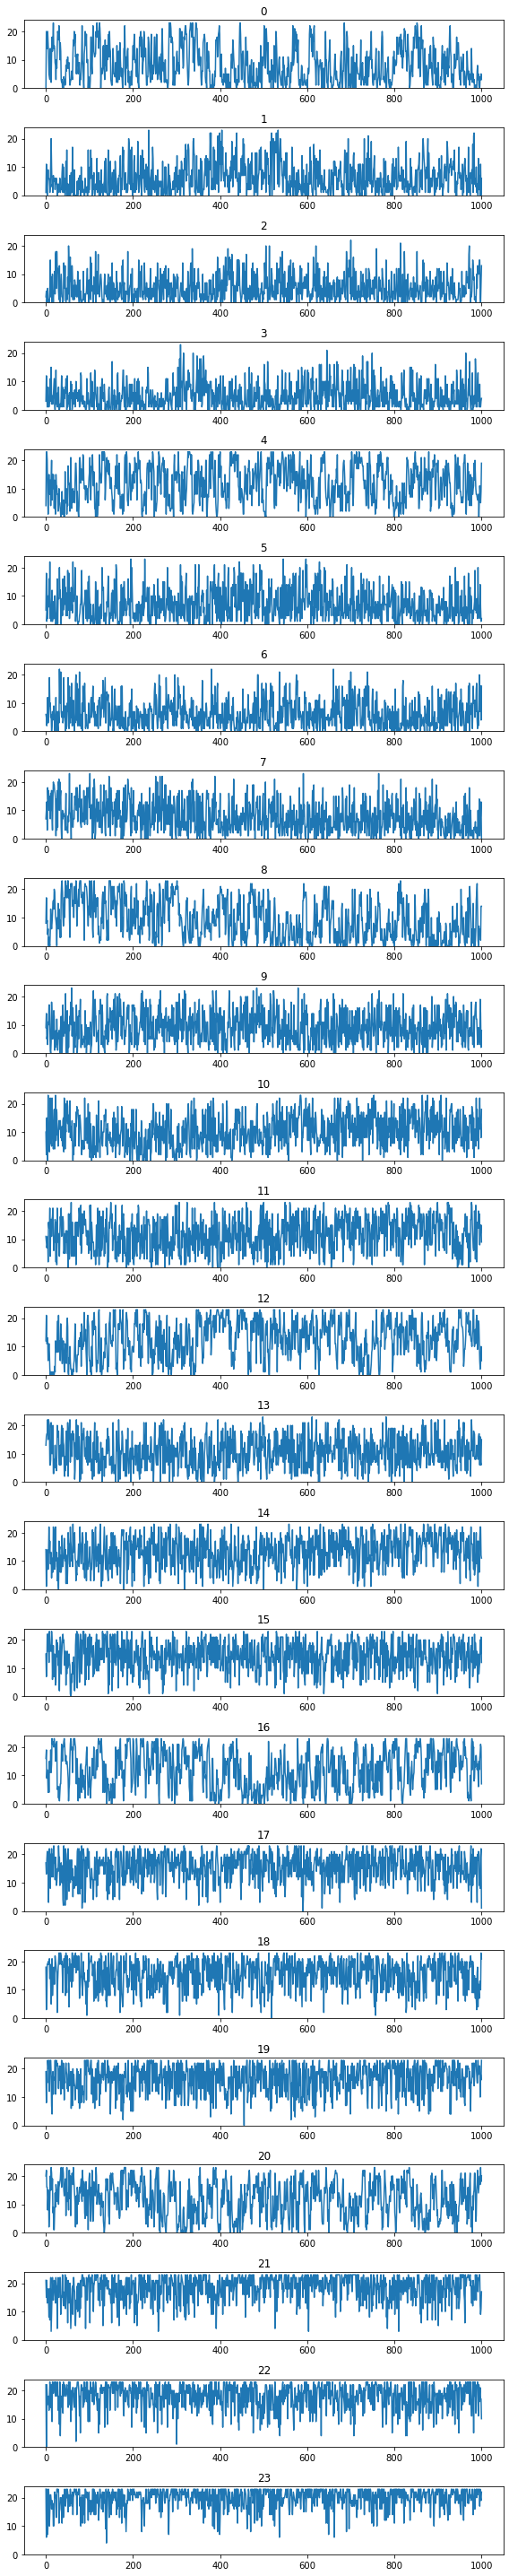

In [6]:
cols = 1
rows = 24
plt.figure(figsize=(8, 40))
gs = plt.GridSpec(rows, cols)
for i, replica_traj in enumerate(replica_trajs):
    plt.subplot(gs[i,0])
    plt.plot(replica_traj)
    plt.title(i)
    plt.ylim([0, 24])

plt.tight_layout()
plt.show()